# **Loan Prediction AWS**

Group 4 Section A

The code shown here encompasses some basic data exploration, along with a following random forest model. The model incorporates stratified k-fold cross validation and grid search to obtain the best figures possible. The Notebook here was build and executed in AWS Sagemaker, and some portions of the code can only be run in the appropriate AWS Sagemaker environment.

In [32]:
import pandas as pd 
import numpy as np                     
import seaborn as sns                 
import matplotlib.pyplot as plt         
import warnings                        
warnings.filterwarnings("ignore")

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# **Data**

For this problem, we have been given two CSV files: train and test

Train file will be used for training the model, i.e. our model will learn from this file. It contains all the independent variables and the target variable.

The test file contains all the independent variables, but not the target variable. We will apply the model to predict the target variable for the test data.

In [3]:
train=pd.read_csv("loan_sanction_train.csv") 
test=pd.read_csv("loan_sanction_test.csv")

Below we use invidual scripts for each renaming to carfully track feature names over Sagemaker, Lambda, and HTML

In [4]:
#Renaming the columns to match HTML and Lambda function (One at a time for easier edits and bug fixes)
train.rename(columns={'Gender': 'gender'}, inplace=True)
train.rename(columns={'Married': 'married'}, inplace=True)
train.rename(columns={'Dependents': 'dependents'}, inplace=True)
train.rename(columns={'Education': 'education'}, inplace=True)
train.rename(columns={'Self_Employed': 'selfEmployed'}, inplace=True)
train.rename(columns={'ApplicantIncome': 'applicantIncome'}, inplace=True)
train.rename(columns={'CoapplicantIncome': 'coapplicantIncome'}, inplace=True)
train.rename(columns={'LoanAmount': 'loanAmount'}, inplace=True)
train.rename(columns={'Loan_Amount_Term': 'loanAmountTerm'}, inplace=True)
train.rename(columns={'Credit_History': 'creditHistory'}, inplace=True)
train.rename(columns={'Property_Area': 'propertyArea'}, inplace=True)
train.rename(columns={'Loan_Status': 'loanStatus'}, inplace=True)


test.rename(columns={'Gender': 'gender'}, inplace=True)
test.rename(columns={'Married': 'married'}, inplace=True)
test.rename(columns={'Dependents': 'dependents'}, inplace=True)
test.rename(columns={'Education': 'education'}, inplace=True)
test.rename(columns={'Self_Employed': 'selfEmployed'}, inplace=True)
test.rename(columns={'ApplicantIncome': 'applicantIncome'}, inplace=True)
test.rename(columns={'CoapplicantIncome': 'coapplicantIncome'}, inplace=True)
test.rename(columns={'LoanAmount': 'loanAmount'}, inplace=True)
test.rename(columns={'Loan_Amount_Term': 'loanAmountTerm'}, inplace=True)
test.rename(columns={'Credit_History': 'creditHistory'}, inplace=True)
test.rename(columns={'Property_Area': 'propertyArea'}, inplace=True)

In [5]:
train.columns

Index(['Loan_ID', 'gender', 'married', 'dependents', 'education',
       'selfEmployed', 'applicantIncome', 'coapplicantIncome', 'loanAmount',
       'loanAmountTerm', 'creditHistory', 'propertyArea', 'loanStatus'],
      dtype='object')

In [6]:
test.columns

Index(['Loan_ID', 'gender', 'married', 'dependents', 'education',
       'selfEmployed', 'applicantIncome', 'coapplicantIncome', 'loanAmount',
       'loanAmountTerm', 'creditHistory', 'propertyArea'],
      dtype='object')

Getting an idea of which data types may have to be altered later.

In [7]:
train.dtypes

Loan_ID               object
gender                object
married               object
dependents            object
education             object
selfEmployed          object
applicantIncome        int64
coapplicantIncome    float64
loanAmount           float64
loanAmountTerm       float64
creditHistory        float64
propertyArea          object
loanStatus            object
dtype: object

In [8]:
train.shape, test.shape

((614, 13), (367, 12))

Is the dataset balanced?

In [9]:
train['loanStatus'].value_counts()

loanStatus
Y    422
N    192
Name: count, dtype: int64

In [10]:

train['loanStatus'].value_counts(normalize=True)

loanStatus
Y    0.687296
N    0.312704
Name: proportion, dtype: float64

422(around 69%) people out of 614 got the approval.

In [11]:
train.head()

,Loan_ID,gender,married,dependents,education,selfEmployed,applicantIncome,coapplicantIncome,loanAmount,loanAmountTerm,creditHistory,propertyArea,loanStatus
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Conducting a correlation matrix to see which features may have the strongest impact on loan approvals.

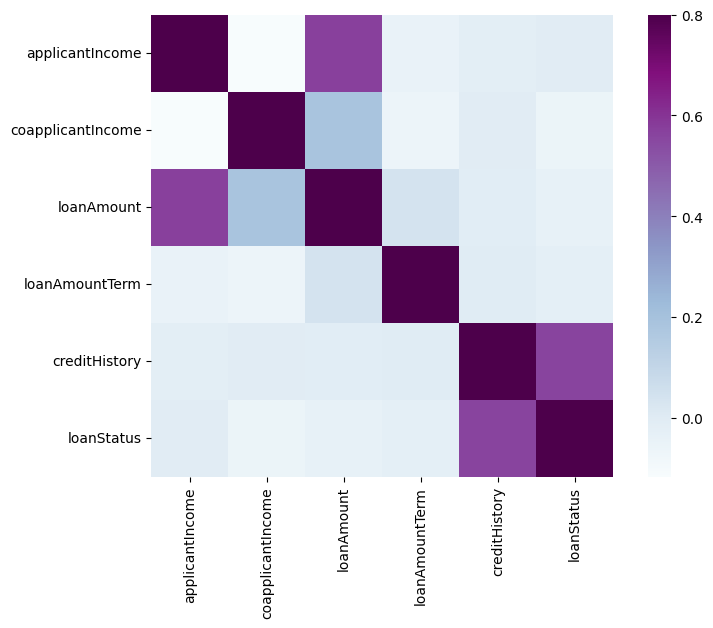

In [16]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the dataframe
train_copy = train.copy()

# Create a label encoder
le = LabelEncoder()

# Transform the loanStatus column so that we can use it in the correlation matrix.
train_copy['loanStatus'] = le.fit_transform(train['loanStatus'])

# Select numerical columns
numerical_columns = train_copy.select_dtypes(include=['number'])

# Calculate the correlation matrix
matrix = numerical_columns.corr()

# Create a heatmap
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(matrix, vmax=0.8, square=True, cmap="BuPu")

# Show the plot
plt.show()

We see that the most correlated variables are (applicantIncome – loanAmount) and (loanStatus - creditHistory). In fact, the only variable which has a significant impact on loanStatus is creditHistory. It is likely that applying for without a credit history will in many cases indicate a denial.

> # **Missing Value and Outlier Treatment**

First we will clean missing values.

In [12]:
train.isnull().sum()

Loan_ID               0
gender               13
married               3
dependents           15
education             0
selfEmployed         32
applicantIncome       0
coapplicantIncome     0
loanAmount           22
loanAmountTerm       14
creditHistory        50
propertyArea          0
loanStatus            0
dtype: int64

* For numerical variables: imputation using mean or median
* For categorical variables: imputation using mode

In [13]:
train['gender'].fillna(train['gender'].mode()[0], inplace=True)
train['married'].fillna(train['married'].mode()[0], inplace=True)
train['dependents'].fillna(train['dependents'].mode()[0], inplace=True)
train['selfEmployed'].fillna(train['selfEmployed'].mode()[0], inplace=True)
train['creditHistory'].fillna(train['creditHistory'].mode()[0], inplace=True)

In [14]:
train['loanAmountTerm'].value_counts()

loanAmountTerm
360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64

It can be seen that in the loan amount term variable, the value of 360 is repeated the most. So we will replace the missing values in this variable using the mode of this variable.

In [15]:
train['loanAmountTerm'].fillna(train['loanAmountTerm'].mode()[0], inplace=True)

In [16]:
train['loanAmount'].fillna(train['loanAmount'].median(), inplace=True)

In [17]:
train.isnull().sum()

Loan_ID              0
gender               0
married              0
dependents           0
education            0
selfEmployed         0
applicantIncome      0
coapplicantIncome    0
loanAmount           0
loanAmountTerm       0
creditHistory        0
propertyArea         0
loanStatus           0
dtype: int64

In [18]:
test['gender'].fillna(train['gender'].mode()[0], inplace=True) 
test['dependents'].fillna(train['dependents'].mode()[0], inplace=True) 
test['selfEmployed'].fillna(train['selfEmployed'].mode()[0], inplace=True) 
test['creditHistory'].fillna(train['creditHistory'].mode()[0], inplace=True) 
test['loanAmountTerm'].fillna(train['loanAmountTerm'].mode()[0], inplace=True) 
test['loanAmount'].fillna(train['loanAmount'].median(), inplace=True)

> # **Outlier Treatment**

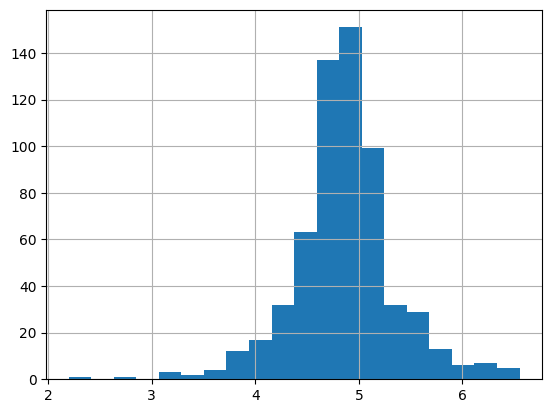

In [19]:
train['loanAmount_log'] = np.log(train['loanAmount']) 
train['loanAmount_log'].hist(bins=20) 
test['loanAmount_log'] = np.log(test['loanAmount'])

Now the distribution looks much closer to normal and the effect of extreme values has been significantly subsided.

> # **Model Building: Random Forest**

We will be using Random Forest for this classification problem. It will yeild higher accuracy than its classification counterparts, but will compromise on model understanding. The model is only meant to suggest a course of action for a banker, and thus does not need to have high visibility since it does not determine the final outcome on the loan.

In [17]:
train=train.drop('Loan_ID',axis=1) 
test=test.drop('Loan_ID',axis=1)

In [18]:
train

,gender,married,dependents,education,selfEmployed,applicantIncome,coapplicantIncome,loanAmount,loanAmountTerm,creditHistory,propertyArea,loanStatus
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [19]:
X = train.drop('loanStatus', axis=1)
y = train['loanStatus']


Now we will make dummy variables for the categorical variables. A dummy variable turns categorical variables into a series of 0 and 1, making them a lot easier to quantify and compare.

Once we apply dummies to a variable lets say 'Gender', it will convert the “Gender” variable into two variables(Gender_Male and Gender_Female), one for each class, i.e. Male and Female.
Gender_Male will have a value of 0 if the gender is Female and a value of 1 if the gender is Male.

In [20]:
X=pd.get_dummies(X) 
train=pd.get_dummies(train) 
test=pd.get_dummies(test)

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_cv, y_train, y_cv = train_test_split(X,y, test_size =0.2)

 # **Comparing Models Using Stratified k-folds Cross-validation**

* Stratification is the process of rearranging the data so as to ensure that each fold is a good representative of the whole.
* For example, in a binary classification problem where each class comprises 50% of the data, it is best to arrange the data such that in every fold, each class comprises about half the instances.
* It is generally a better approach when dealing with both bias and variance.
* A randomly selected fold might not adequately represent the minor class, particularly in cases where there is a huge class imbalance.

Attempting a Random Forest Model

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y): 
    print('n{} of kfold {}'.format(i,kf.n_splits)) 
    xtr,xvl = X.loc[train_index],X.loc[test_index] 
    ytr,yvl = y[train_index],y[test_index] 
    model = RandomForestClassifier(random_state=1, max_depth=10)     
    model.fit(xtr, ytr) 
    pred_test = model.predict(xvl) 
    score = accuracy_score(yvl,pred_test) 
    print('accuracy_score',score) 
    i+=1 
pred_test = model.predict(test)

n1 of kfold 5
accuracy_score 0.8130081300813008
n2 of kfold 5
accuracy_score 0.8455284552845529
n3 of kfold 5
accuracy_score 0.7967479674796748
n4 of kfold 5
accuracy_score 0.8211382113821138
n5 of kfold 5
accuracy_score 0.7622950819672131


Attempting a Decision Tree Model

In [28]:
from sklearn.tree import DecisionTreeClassifier

i = 1
kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

for train_index, test_index in kf.split(X, y):
    print('n{} of kfold {}'.format(i, kf.n_splits))
    xtr, xvl = X.loc[train_index], X.loc[test_index]
    ytr, yvl = y[train_index], y[test_index]

    model = DecisionTreeClassifier(random_state=1)
    model.fit(xtr, ytr)

    pred_test = model.predict(xvl)
    score = accuracy_score(yvl, pred_test)
    print('accuracy_score', score)

    i += 1

pred_test = model.predict(test)

n1 of kfold 5
accuracy_score 0.7073170731707317
n2 of kfold 5
accuracy_score 0.6829268292682927
n3 of kfold 5
accuracy_score 0.6910569105691057
n4 of kfold 5
accuracy_score 0.7073170731707317
n5 of kfold 5
accuracy_score 0.6557377049180327


As expected, a Random Forest will outperform a Decision Tree.

After looking at the folds in RF, we can see that accuracy is in a wide range from ~75% to ~85% so we will do a grid search in an attempt to find optimal parameters for this model.

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


paramgrid = {'max_depth': list(range(1, 20, 2)),
             'n_estimators': list(range(1, 200, 20))}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), paramgrid)

# Fit the grid search model
grid_search.fit(x_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 3, 'n_estimators': 181}


In [24]:
# Estimating the optimized value

grid_search.best_estimator_

RandomForestClassifier(max_depth=3, n_estimators=181, random_state=42)

After applying the optimied grid search parameters below, we can find that the range of accuracies in the fold drops to ~80% - ~85% resulting in a better model. However, we can also see that to achieve a high accuracy and precision there were tradeoffs made in recall. The model has a low risk of making an error when predicting that someone didn't get a loan. Unfortunetely, there will be individuals who should not get loans but will be labed as loan approved. This low recall is observant towards actual banking practices.

In [26]:
from sklearn.metrics import classification_report

i = 1
kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

for train_index, test_index in kf.split(X, y):
    print('\nFold {} of {} k-folds'.format(i, kf.n_splits))
    xtr, xvl = X.loc[train_index], X.loc[test_index]
    ytr, yvl = y[train_index], y[test_index]

    model = RandomForestClassifier(random_state=42, max_depth=3, n_estimators=181)
    model.fit(xtr, ytr)

    pred_test = model.predict(xvl)
    score = accuracy_score(yvl, pred_test)
    print('Accuracy Score:', score)

    # Print classification report
    print('Classification Report:')
    print(classification_report(yvl, pred_test))

    i += 1

# Assuming 'test' is your test data
pred_test = model.predict(test)
pred_prob_test = model.predict_proba(test)[:, 1]


Fold 1 of 5 k-folds
Accuracy Score: 0.8130081300813008
Classification Report:
              precision    recall  f1-score   support

           N       0.86      0.47      0.61        38
           Y       0.80      0.96      0.88        85

    accuracy                           0.81       123
   macro avg       0.83      0.72      0.74       123
weighted avg       0.82      0.81      0.79       123


Fold 2 of 5 k-folds
Accuracy Score: 0.8373983739837398
Classification Report:
              precision    recall  f1-score   support

           N       1.00      0.47      0.64        38
           Y       0.81      1.00      0.89        85

    accuracy                           0.84       123
   macro avg       0.90      0.74      0.77       123
weighted avg       0.87      0.84      0.82       123


Fold 3 of 5 k-folds
Accuracy Score: 0.7967479674796748
Classification Report:
              precision    recall  f1-score   support

           N       0.94      0.38      0.55        39


# **Saving Joblib to S3**

The code below outlines the process to save the model to an S3 bucket where it can be later called on to make predictions.

In [ ]:
import joblib
from sagemaker.s3 import S3Uploader

model_filename = '_model.joblib'
joblib.dump(model, model_filename)

# Upload the model artifacts to S3
s3_model_path = S3Uploader.upload(model_filename, 's3://model-bucket-mihir/model-path/')

Checking the feature names to see the input needed to make predictions. This will be needed for the AWS Lambda cleaning.

In [1]:
import joblib

# Path to your model file
model_path = '_model.joblib'

# Load the model
model = joblib.load(model_path)


if hasattr(model, 'feature_names_in_'):
    print("Feature names in the model:")
    print(model.feature_names_in_)
elif hasattr(model, 'get_feature_names_out'):
    
    print("Feature names out of the model:")
    print(model.get_feature_names_out())
else:
    print("The model does not have an attribute to directly list feature names.")


Feature names in the model:
['applicantIncome' 'coapplicantIncome' 'loanAmount' 'loanAmountTerm'
 'creditHistory' 'loanAmount_log' 'gender_Female' 'gender_Male'
 'married_No' 'married_Yes' 'dependents_0' 'dependents_1' 'dependents_2'
 'dependents_3+' 'education_Graduate' 'education_Not Graduate'
 'selfEmployed_No' 'selfEmployed_Yes' 'propertyArea_Rural'
 'propertyArea_Semiurban' 'propertyArea_Urban']
